In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [34]:
# load the LCMS cleaned data file
clean_data = np.load('../../data/processed/lcms_union_clean_data.npy', allow_pickle=True).item()

In [37]:
# for day 1 and day 2, split into morning and afternoon
# day 1 
day1_morning = clean_data['data_day1'][:, :26]
day1_afternoon = clean_data['data_day1'][:, 26:]
# day 2
day2_morning = clean_data['data_day2'][:, :32]
day2_afternoon = clean_data['data_day2'][:, 32:]
# day3 -- no need for splitting (unique recording session)
day3 = clean_data['data_day3']
# print shapes
day1_morning.shape, day1_afternoon.shape, day2_morning.shape, day2_afternoon.shape, day3.shape

# consider the delay of 15 minutes -- i.e. 2 bins delay for the hormones in order to be aligned with speed
X1m = day1_morning[:, 2:]  # remove first two samples to align with behavior
X1a = day1_afternoon[:, 2:]  # remove first two samples to align with behavior
X2m = day2_morning[:, 2:]  # remove first two samples to align with behavior
X2a = day2_afternoon[:, 2:]  # remove first two samples to align with behavior
X3 = day3[:,2:] # remove first 15 minutes

In [38]:
# load speed aligned and preprocessed data
preprocessed_data = np.load('../../data/processed/compounds_aligned_speed.npy', allow_pickle=True).item()
y1m = preprocessed_data['y1m']
y1a = preprocessed_data['y1a']
y2m = preprocessed_data['y2m']
y2a = preprocessed_data['y2a']
y3 = preprocessed_data['y3']

In [39]:
# fill nans with simple linear interpolation
from scipy.interpolate import interp1d
def fill_nan_with_interpolation(arr):
    nans = np.isnan(arr)
    if np.all(nans):
        return arr  # return as is if all values are NaN
    x = np.arange(len(arr))
    f = interp1d(x[~nans], arr[~nans], kind=1, bounds_error=False, fill_value="extrapolate")
    return f(x)
# fill nan for X datasets
X1m = np.array([fill_nan_with_interpolation(row) for row in X1m])
X1a = np.array([fill_nan_with_interpolation(row) for row in X1a])
X2m = np.array([fill_nan_with_interpolation(row) for row in X2m])
X2a = np.array([fill_nan_with_interpolation(row) for row in X2a])
X3 = np.array([fill_nan_with_interpolation(row) for row in X3])

In [40]:
# concatenate X1
X1_full = np.hstack((X1m, np.zeros((X1m.shape[0], 9))*np.nan, X1a))
X1_full = np.vstack([X1_full, np.zeros((X3.shape[0]-X1_full.shape[0], X1_full.shape[1]))*np.nan])
y1_full = np.hstack((y1m, np.zeros(9)*np.nan, y1a))
# concatenate X2
X2_full = np.hstack((X2m, np.zeros((X2m.shape[0], 9))*np.nan, X2a))
X2_full = np.vstack([X2_full, np.zeros((X3.shape[0]-X2_full.shape[0], X2_full.shape[1]))*np.nan])
y2_full = np.hstack((y2m, np.zeros(9)*np.nan, y2a))

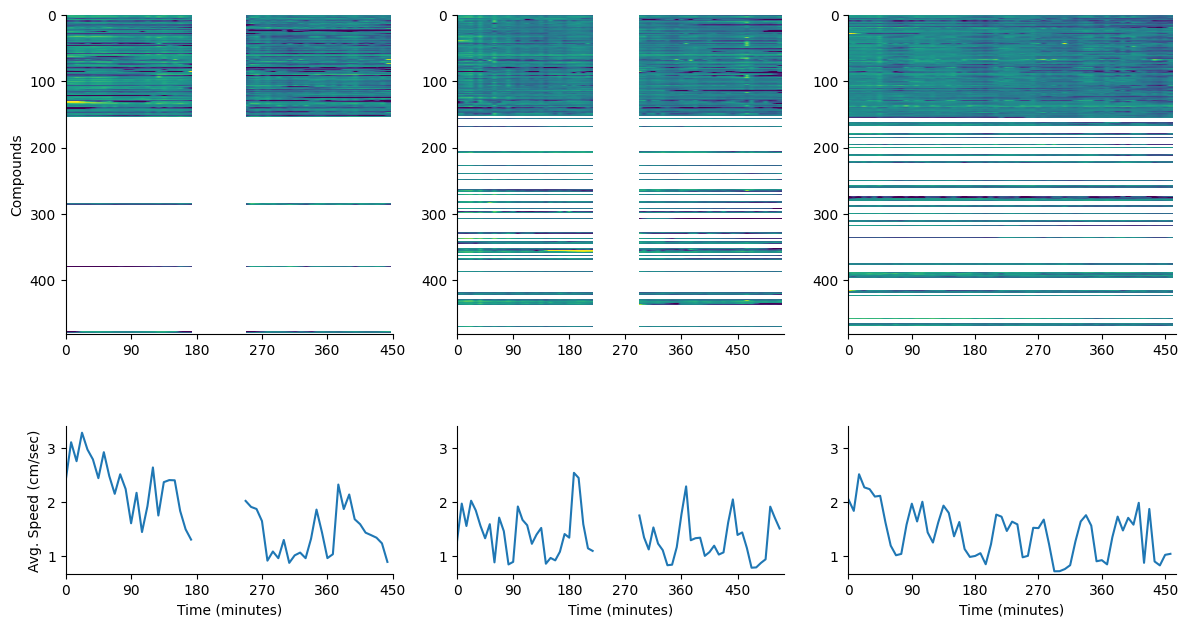

In [42]:
def anim_comps_speed(X, y, title='', pos=0):
    plt.subplot(2, 3, 1 + pos)
    plt.imshow(X, aspect='auto', cmap='viridis',vmin=-2.3, vmax=2.3, rasterized=True)
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    if title[-1] == '1':
        plt.ylabel('Compounds')
    plt.xlim(0,len(y))
    # remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.subplot(4, 3, 7 + pos)
    plt.plot(y)
    plt.ylim(0.67, 3.4)
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    plt.xlabel('Time (minutes)')
    if title[-1] == '1':
        plt.ylabel('Avg. Speed (cm/sec)')
    plt.xlim(0,len(y))
    # remove spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)


plt.figure(figsize=(12, 8))
anim_comps_speed(X1_full, y1_full, title='Day 1', pos=0)
anim_comps_speed(X2_full, y2_full, title='Day 2', pos=1)
anim_comps_speed(X3, y3, title='Day 3', pos=2)
plt.tight_layout()
plt.savefig('../../figures/fig1/heatmaps_union_compounds_aligned_full.pdf', dpi=900)